In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random
from torch.nn import init
from sklearn.decomposition import TruncatedSVD


if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

### Подготовим датасет, для наглядности симулирующий высказывание - "Смысл слова определяется его контекстом". Фрукты, животные и напитки используются в одном контексте, значит нам будет не сложно выучить векторные представления для них.

In [2]:
dataset = ["apple banana fruit banana orange fruit orange banana fruit apple fruit orange",
           "dog cat animal cat monkey animal monkey dog animal dog cat animal cat monkey animal",
           "cola beer water beer cola water water beer cola water cola beer cola water beer"]

In [4]:
class Word2vecDataset(Dataset):
    def __init__(self, dataset, window_size):
        self.dataset = dataset
        self.word_list = " ".join(dataset).split()
        self.window_size = window_size
        self.corpus_words = list(set(self.word_list))
        self.word2idx = {word:idx for idx, word in enumerate(self.corpus_words)}
        self.word2idx['UNK'] = len(self.corpus_words)
        self.idx2word = {idx:word for word, idx in self.word2idx.items()}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        random_sentence = random.choice(self.dataset).split()
        random_word = random.choice(random_sentence)
        w2v_input_list = []
        central_word_idx = self.word2idx[random_word]
        left_window = max(idx - self.window_size, 0)
        rigth_window = min(idx + self.window_size + 1, len(random_sentence))
        for window_idx, context_word in enumerate(random_sentence[left_window:rigth_window]):
          context_word_idx = self.word2idx[context_word]
          if central_word_idx != context_word_idx or window_idx + self.window_size + 1 != len(random_sentence[left_window:rigth_window]):
            w2v_input_list.append((central_word_idx, context_word_idx))
        return w2v_input_list

    def collate(self, batches):
        all_u = [u for batch in batches for u, _ in batch if len(batch) > 0]
        all_v = [v for batch in batches for _, v in batch if len(batch) > 0]
        return torch.LongTensor(all_u), torch.LongTensor(all_v)

def test():
  w2v_test_loader = Word2vecDataset(dataset, 2)
  first_input = w2v_test_loader[1]
  print(w2v_test_loader.word2idx)
  for central_word_idx, context_word_idx in first_input:
    print('Central word: ', w2v_test_loader.idx2word[central_word_idx])
    print('Context word: ', w2v_test_loader.idx2word[context_word_idx])
    print()

test()

{'fruit': 0, 'cat': 1, 'apple': 2, 'animal': 3, 'cola': 4, 'beer': 5, 'banana': 6, 'dog': 7, 'orange': 8, 'water': 9, 'monkey': 10, 'UNK': 11}
Central word:  animal
Context word:  dog

Central word:  animal
Context word:  cat

Central word:  animal
Context word:  animal

Central word:  animal
Context word:  cat



Как мы ищем эмбеддинг слова?

![look_up_table example](https://neuro.cs.ut.ee/wp-content/uploads/2018/09/embeddings.png)

#Архитектура skip-gram W2V


![skip_gram](https://static-01.hindawi.com/articles/wcmc/volume-2019/2121850/figures/2121850.fig.002b.svgz)

## $ {Objective}(score) = -\log (\frac{ 1 }{ 1 + \exp(-x)}) $


In [5]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGramModel, self).__init__()
        self.u_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.v_embeddings = nn.Embedding(vocab_size, embed_dim)

        initrange = 1.0 / embed_dim
        init.uniform_(self.u_embeddings.weight.data, -initrange, initrange)
        init.uniform_(self.v_embeddings.weight.data, -initrange, initrange)

    def forward(self, pos_u, pos_v):
        emb_u = self.u_embeddings(pos_u)
        emb_v = self.v_embeddings(pos_v)

        score = torch.sum(torch.mul(emb_u, emb_v), dim=1)
        score = torch.clamp(score, max=10, min=-10)
        score = -F.logsigmoid(score)

        return torch.mean(score)


def test():
  LEARNING_RATE = 1e-5
  BATCH_SIZE = 3
  w2v_test_loader = Word2vecDataset(dataset, 2)
  dataloader = DataLoader(w2v_test_loader, batch_size=BATCH_SIZE, collate_fn=w2v_test_loader.collate)
  test_w2v_model = SkipGramModel(vocab_size = len(w2v_test_loader.word2idx), embed_dim=2)
  optimizer = optim.Adam(test_w2v_model.parameters(), lr=LEARNING_RATE)
  first_input = list(dataloader)[0]
  print(first_input)
  print('Model loss: ', test_w2v_model.forward(pos_u=first_input[0], pos_v=first_input[1]))

test()

(tensor([7, 7, 8, 8, 8, 8, 4, 4, 4, 4, 4]), tensor([1, 3, 2, 6, 0, 6, 4, 5, 9, 5, 4]))
Model loss:  tensor(0.7309, grad_fn=<MeanBackward0>)


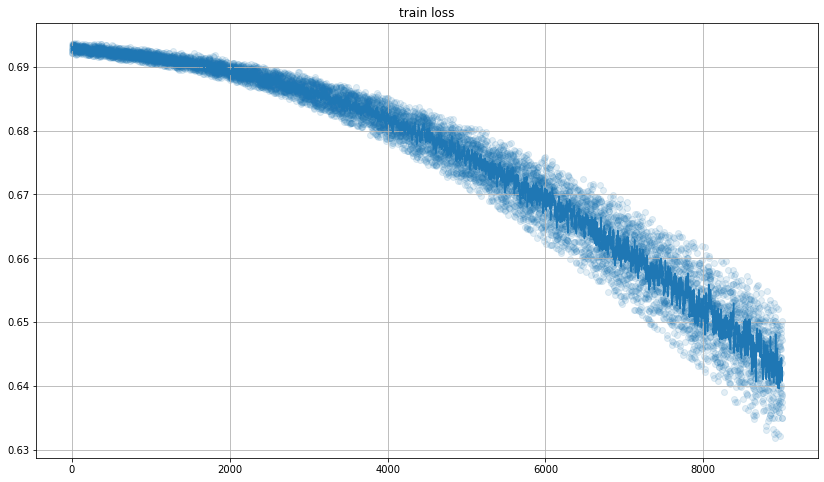

Epoch number = 9000, Val acc = 0.6348933577537537


In [6]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-5

PLOT_EVERY=1000
PRINT_EVERY=1000

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

w2v_loader = Word2vecDataset(dataset=dataset, window_size=2)
dataloader = DataLoader(w2v_loader, batch_size=BATCH_SIZE, collate_fn=w2v_loader.collate)

w2v_model = SkipGramModel(vocab_size = len(w2v_loader.word2idx), embed_dim=30).to(dev)
optimizer = optim.Adam(w2v_model.parameters(), lr=LEARNING_RATE)

EPOCH_NUM = 10000
loss_array = []
for epoch in range(EPOCH_NUM):
  loss_per_epoch = 0
  for batch in dataloader:
    pos_u = batch[0].to(dev)#central word
    pos_v = batch[1].to(dev)#context word
    optimizer.zero_grad()
    loss = w2v_model.forward(pos_u, pos_v)
    loss.backward()
    optimizer.step()
    loss_per_epoch += loss.item()

  loss_array.append(loss_per_epoch)

  if epoch % PLOT_EVERY == 0:
    clear_output(True)
    plt.figure(figsize=[14, 8])

    plt.subplot(1, 1, 1), plt.title('train loss'), plt.grid()
    plt.scatter(np.arange(len(loss_array)), loss_array, alpha=0.12)
    plt.plot(ewma(loss_array, span=10))
    plt.show()

  if epoch % PRINT_EVERY == 0:
    print('Epoch number = {0}, Val acc = {1}'.format(epoch, loss_array[-1]))

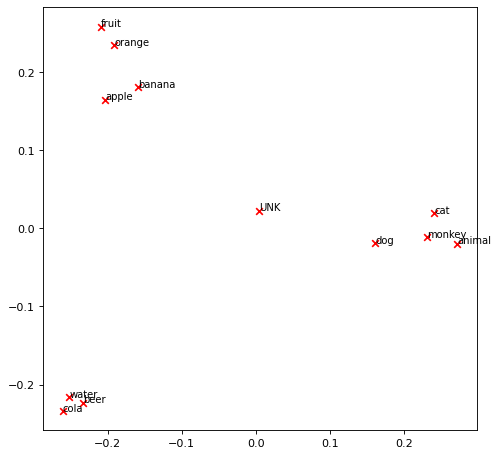

In [7]:
def reduce_to_k_dim(M, k=2):
    n_iters = 10 
    trunc_svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    M_reduced = trunc_svd.fit_transform(M)
    return M_reduced


def plot_embeddings(embedding_matrix, words):
    assert embedding_matrix.shape[1] == 2

    plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')

    x_values = embedding_matrix[:,0]
    y_values = embedding_matrix[:,1]
    for i, word in enumerate(words):
        x = x_values[i]
        y = y_values[i]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)
    plt.show()

corpus_words = w2v_loader.word2idx.keys()
embeddings = reduce_to_k_dim(w2v_model.u_embeddings.weight.cpu().data.numpy())
plot_embeddings(embeddings, corpus_words)